## Initial imports

In [1]:
import os
import warnings
import random
os.environ["KERAS_BACKEND"] = "tensorflow"
warnings.filterwarnings('ignore')
random.seed(17)

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error

from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Data Read

In [2]:
directory_path = "../data/stocks/training"
contents = sorted([filename.replace(".csv", "") for filename in os.listdir(directory_path)])

def read_data_for_symbol(symbol):
    training_data = pd.read_csv(
        os.path.join(directory_path, f"{symbol}.csv"),
        index_col=0
    )
    training_data['Date'] = pd.to_datetime(training_data['Date'])

    return training_data

symbol_to_start_end_diff = list()
for symbol in contents:
    data = read_data_for_symbol(symbol)
    min_close = data['Close'].min()
    max_close = data['Close'].max()
    start_close = data.loc[0, 'Close']
    end_close = data.loc[data.shape[0] - 1, 'Close']
    max_min = max_close - min_close
    end_start = end_close - start_close

    if end_start < 0:
        continue

    avg_vol = (max_min + end_start) / 2

    if np.isclose(avg_vol, 0):
        continue

    symbol_to_start_end_diff.append([symbol, avg_vol])

symbol_to_start_end_diff = sorted(symbol_to_start_end_diff, key=lambda x: x[1])

symbols_to_train = list()

def add_picked(picked):
    for symbol, avg_vol in picked:
        symbols_to_train.append(symbol)

# low price variance
picked = symbol_to_start_end_diff[ : 5]
print(len(picked))
add_picked(picked)
# max price variance
picked = symbol_to_start_end_diff[len(symbol_to_start_end_diff) - 5 : ]
print(len(picked))
add_picked(picked)
# 1/4 price variance
start = int(len(symbol_to_start_end_diff) / 4) - 3
picked = symbol_to_start_end_diff[start : start + 5]
print(len(picked))
add_picked(picked)
# 1/2 price variance
start = int(len(symbol_to_start_end_diff) / 2) - 3
picked = symbol_to_start_end_diff[start : start + 5]
print(len(picked))
add_picked(picked)
# 3/4 price variance
start = int(len(symbol_to_start_end_diff) * 3 / 4) - 3
picked = symbol_to_start_end_diff[start : start + 5]
print(len(picked))
add_picked(picked)
# 5 random symbols
picked = random.choices(symbol_to_start_end_diff, k=5)
print(len(picked))
add_picked(picked)

print(symbols_to_train)
print(len(symbols_to_train))
random.shuffle(symbols_to_train)
print(symbols_to_train)


5
5
5
5
5
5
['EVOXU', 'WSTNU', 'LKSP', 'HAVAU', 'MMTXU', 'KLAC', 'FICO', 'CBIO', 'BKNG', 'NVR', 'RFIL', 'NRT', 'MUC', 'ELA', 'EXOZ', 'BIPC', 'RMR', 'BSAC', 'ARMK', 'NTGR', 'SCI', 'BRKRP', 'MTH', 'ALSN', 'EXEEZ', 'AUDC', 'COP', 'CEG', 'UEC', 'PNW']
30
['ALSN', 'FICO', 'BIPC', 'KLAC', 'EXEEZ', 'NTGR', 'ARMK', 'NRT', 'NVR', 'SCI', 'EXOZ', 'AUDC', 'UEC', 'CEG', 'LKSP', 'WSTNU', 'MMTXU', 'PNW', 'RFIL', 'RMR', 'COP', 'ELA', 'MUC', 'CBIO', 'EVOXU', 'HAVAU', 'BKNG', 'BRKRP', 'BSAC', 'MTH']


In [3]:
def plot_close_prices(data_to_plot):
    # Plot the actual 'Close' prices over time
    plt.figure(figsize=(12, 6))
    plt.plot(data_to_plot['Date'], data_to_plot['Close'], label='Actual Stock Price')
    plt.title('Apple Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
# Feature engineering: Adding moving averages and price changes

def add_extra_features(data_to_use):
    updated_data = data_to_use.copy(deep=True)

    # MR50 = Mean Rolling 50 days
    updated_data['MA50'] = updated_data['Close'].rolling(50).mean()
    # MR200 = Mean Rolling 200 days
    updated_data['MA200'] = updated_data['Close'].rolling(200).mean()
    # PDC = Previous Day Close
    updated_data['PDC'] = updated_data['Close'].shift(1)
    # CC = Change in Close
    updated_data['CC'] = updated_data['Close'] - updated_data['PDC']
    # PCC = Percent Change Close
    updated_data['PCC'] = updated_data['Close'].pct_change()

    updated_data.fillna(method='bfill', inplace=True)

    return updated_data


In [5]:
def scale_values_and_make_scaler(data_to_scale):
    scaled_data = data_to_scale.copy(deep=True)

    Close_Scaler = MinMaxScaler()
    scaled_data[['Close_Scaled']] = Close_Scaler.fit_transform(scaled_data[['Close']])

    # MA50_Scaler = MinMaxScaler()
    # scaled_data[['MA50_Scaled']] = MA50_Scaler.fit_transform(scaled_data[['MA50']])

    # MA200_Scaler = MinMaxScaler()
    # scaled_data[['MA200_Scaled']] = MA200_Scaler.fit_transform(scaled_data[['MA200']])

    # PDC_Scaler = MinMaxScaler()
    # scaled_data[['PDC_Scaled']] = PDC_Scaler.fit_transform(scaled_data[['PDC']])

    # CC_Scaler = MinMaxScaler()
    # scaled_data[['CC_Scaled']] = CC_Scaler.fit_transform(scaled_data[['CC']])

    # PCC_Scaler = MinMaxScaler()
    # scaled_data[['PCC_Scaled']] = PCC_Scaler.fit_transform(scaled_data[['PCC']])

    return scaled_data, Close_Scaler


In [6]:
# Function to create sequences (for single column data)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [7]:
def get_X_y_for_data(data_to_use):
    seq_length = 60  
    X, y = create_sequences(data_to_use[["Close_Scaled"]].to_numpy(), seq_length)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y


In [8]:
# Split data to train and test and validation
def split_data(X, y):
    train_size = int(len(X) * 0.7)
    test_size = int(len(X) * 0.2) + train_size

    X_train, X_test, X_validation = X[:train_size], X[train_size:test_size + 1], X[test_size:]
    y_train, y_test, y_validation = y[:train_size], y[train_size:test_size + 1], y[test_size:]

    print("=" * 10)
    print("Details of features (X)")
    print("# of training rows:", len(X_train), ", and shape:", X_train.shape)
    print("# of test rows:", len(X_test), ", and shape:", X_test.shape)
    print("# of validation rows:", len(X_validation), ", and shape:", X_validation.shape)
    print("# of total rows:", len(X))
    print("=" * 10)
    print("Details of result (y)")
    print("# of training rows:", len(y_train), ", and shape:", y_train.shape)
    print("# of test rows:", len(y_test), ", and shape:", y_test.shape)
    print("# of validation rows:", len(y_validation), ", and shape:", y_validation.shape)
    print("# of total rows:", len(y))
    print("=" * 10)

    return X_train, X_test, X_validation, y_train, y_test, y_validation


## CNN-LSTM Model

In [9]:
def make_model():
    model = Sequential([
        # 60 x 1 = 60 days of data, each day represented as an array of 1 element
        LSTM(100, return_sequences=True, input_shape=(60, 1)),
        Dropout(0.4),
        LSTM(100),
        Dropout(0.4),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

def make_callbacks(model_weight_filename):
    checkpoints = ModelCheckpoint(filepath=model_weight_filename, save_best_only = True, save_weights_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    early_stop = EarlyStopping()

    return [checkpoints, reduce_lr, early_stop]

def train_model_on_input(model, callbacks, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        verbose=1,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )
    return history, model


In [10]:
def plot_history(history):
    # Visualize the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Number of iterations: 30
Training for symbol: ALSN
Details of features (X)
# of training rows: 2366 , and shape: (2366, 60, 1)
# of test rows: 677 , and shape: (677, 60, 1)
# of validation rows: 338 , and shape: (338, 60, 1)
# of total rows: 3380
Details of result (y)
# of training rows: 2366 , and shape: (2366,)
# of test rows: 677 , and shape: (677,)
# of validation rows: 338 , and shape: (338,)
# of total rows: 3380
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0018 - val_loss: 7.4463e-04 - learning_rate: 0.0010
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.6708e-04 - val_loss: 7.4456e-04 - learning_rate: 0.0010
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.9528e-04 - val_loss: 3.5109e-04 - learning_rate: 0.0010
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.6874e-04 - val_loss: 6.8576e-04 - learning_rate: 0.0010
Training for symbol: FICO
Details of features (X)
# of training rows: 6717 , and shape: (6717, 60, 1)
# of test r

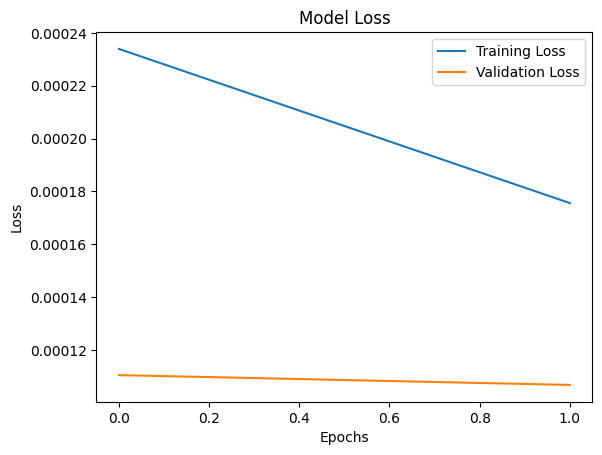

In [11]:
data_for_later = dict()
history = None
model_weight_filename = 'stocks-lstm.weights.h5'
model = make_model()
callbacks = make_callbacks(model_weight_filename)

print("Number of iterations:", len(symbols_to_train))
for symbol in symbols_to_train:
    print(f"Training for symbol: {symbol}")
    data = read_data_for_symbol(symbol)
    data, scaler = scale_values_and_make_scaler(data)
    try:
        X, y = get_X_y_for_data(data)
    except Exception as exp:
        print(f"Failed to train data for '{symbol}'")
        continue

    X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(X, y)
    data_for_later[symbol] = {
        "scaler": scaler,
        "X_train": X_train,
        "X_test": X_test,
        "X_validation": X_validation,
        "y_train": y_train,
        "y_test": y_test,
        "y_validation": y_validation,
    }

    history, model = train_model_on_input(model, callbacks, X_train, y_train, X_test, y_test)

model.save_weights(model_weight_filename, overwrite=True)
json_config = model.get_config()
with open("model_config.json", "w") as json_file:
    json.dump(json_config, json_file)

plot_history(history)